# <h1 style="text-align: center; font-size: 36px; color: #3498db; font-weight: bold;">Prosody Application</h1>
## <h2 style="text-align: center; font-size: 28px; color: #2ecc71; font-weight: bold;">Emotion Recognation</h2>


In [7]:
############################
#@author: Eyad Alkostantini
############################

import os 
import pickle
import pyaudio
import numpy as np
import librosa
import wave
import pandas as pd
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import tensorflow as tf 

In [8]:
#########################################################################################################
# Cloud Folder
if not os.path.exists("Output"):
    import gdown
    folder_url =r"https://drive.google.com/drive/folders/1EZL6Ejoa5GH8DzoZcjvRAonlgWznEh14?usp=drive_link" 
    gdown.download_folder(folder_url)
##########################################################################################################


In [9]:
###############################################
# loding the model, weights, scaler and encoder
###############################################

prosody_model = tf.keras.models.load_model(r'./Output/Prosody_Model.keras')
print ("Prosody Model has been loaded")

# loding the Scaler
with open(r"./Output/Prosody_Scaler.pickle", 'rb') as f:
    prosody_scaler = pickle.load(f)

# loding the Encoder    
with open(r"./Output/Prosody_Encoder.pickle", 'rb') as f:
    prosody_Encoder = pickle.load(f)

Prosody Model has been loaded


In [10]:
#####################################
# geting the features from the voice
#####################################

## ZCR: Zero Crossing Rate: The rate of sign changes of the signal during the duration of a particular frame
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

## RMS: root mean square value
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

## MFCC: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

## Extraxing the features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result

###############################
# features extraxtion function
###############################
def get_features(path):
    data, sr= librosa.load(path, duration=2.5, offset=0) # Extract for 2.5 seconds
    result=extract_features(data)
    result=np.array(result)
    result = np.reshape(result, (1, -1))
    result = prosody_scaler.transform(result)  # Scaler
    return result

######################
# Prediction function
######################
def prediction(path):
    result = get_features(path)
    prediction = prosody_model.predict(result)
    y_prediction = prosody_Encoder.inverse_transform(prediction.reshape(1, -1))
    predicted_class = y_prediction[0][0]
    # class probabilities
    predicted_probs = prediction[0]
    # class names from encoder
    class_names = prosody_Encoder.categories_[0]
    ''''
    # Print predicted class and probabilities for all classes
    print("Predictions for all classes:")
    for label, prob in zip(class_names, predicted_probs):
        print(f"{label}: {prob*100:.2f}%")
    '''
    return predicted_class, predicted_probs


## <h2 style="text-align: left; font-size: 28px; color: #2ecc71; font-weight: bold;">Real-Time Prediction</h2>

Listening...
1/1 [==============================] - 0s 33ms/step


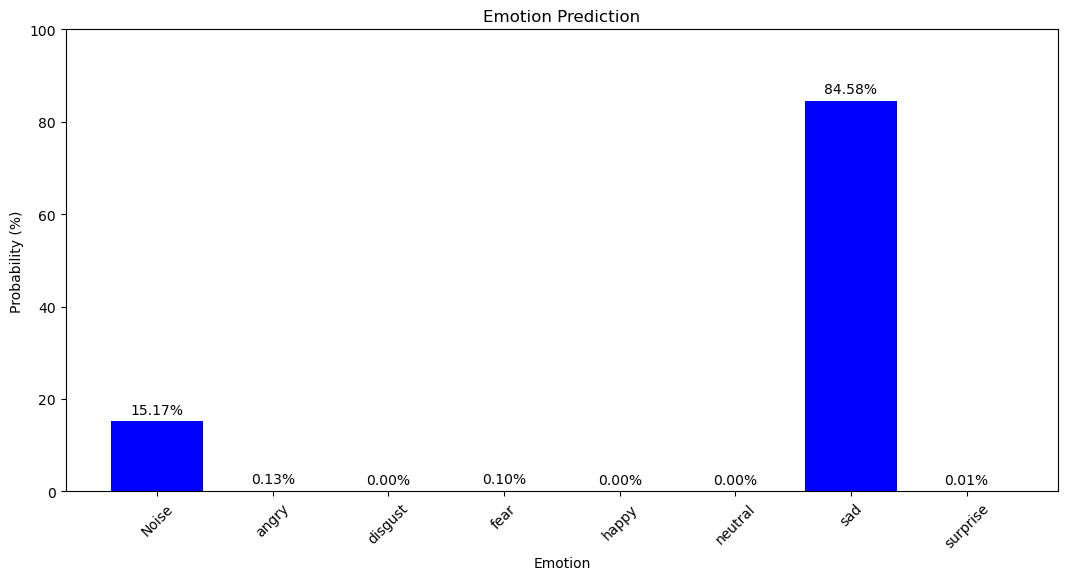

In [32]:
import time  # Import time module for sleep function

#######################
# Real-Time prediction
#######################

class EmotionPlotter:
    def __init__(self, root, update_callback):
        self.root = root
        self.root.title("Emotion Prediction")
        self.update_callback = update_callback
        self.class_names = ['Noise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=45)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        #########################
        # Recording configuration
        #########################
        self.RECORD_SECONDS = 2.5  # recording duration
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.CHUNK = 1024
        self.CHUNK_SIZE = 1024
        self.OUTPUT_FILE = "recorded_audio.wav"
        ########################
        # start button
        ########################
        self.start_button = tk.Button(self.root, text="Start Recording", command=self.start_visualization, font=('Helvetica', 14))
        self.start_button.pack(side=tk.TOP, pady=10)
        self.visualizing = False                 # track of visualization state

        
    def start_visualization(self):
        if not self.visualizing:
            self.visualizing = True
            self.start_button['state'] = tk.DISABLED
            self.update_loop()
        
    def update_loop(self):
        ########################
        # Start recording audio
        ########################
        self.update_gui_text("Recording in Progress...")
        print("Listening...")
        audio = pyaudio.PyAudio()
        stream = audio.open(format=self.FORMAT, channels=self.CHANNELS, rate=self.RATE, input=True, frames_per_buffer=self.CHUNK)
        frames = []
        # Recording 
        for i in range(0, int(self.RATE / self.CHUNK_SIZE * self.RECORD_SECONDS)):
            data = stream.read(self.CHUNK_SIZE)
            frames.append(data)
        # Stop recording
        stream.stop_stream()
        stream.close()
        audio.terminate()
        # Saving audio
        with wave.open(self.OUTPUT_FILE, 'wb') as wf:
            wf.setnchannels(self.CHANNELS)
            wf.setsampwidth(audio.get_sample_size(self.FORMAT))
            wf.setframerate(self.RATE)
            wf.writeframes(b''.join(frames))

        ####################
        # Perform prediction
        ####################
        self.update_gui_text("Start Recording")
        predicted_class, predicted_probs = prediction(self.OUTPUT_FILE)
        # callback
        self.update_callback(self, predicted_class, predicted_probs)
        # Reset visualization
        self.visualizing = False
        self.start_button['state'] = tk.NORMAL

    def update_gui_text(self, text):
        self.start_button.config(text=text)
        self.root.update()

    ########################
    # Update Plot
    ########################
    def update_plot(self, predicted_probs):
        self.ax.clear()
        bars = self.ax.bar(self.class_names, predicted_probs * 100, color='blue')
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=45)
        for i, bar in enumerate(bars):
            self.ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{predicted_probs[i]*100:.2f}%', ha='center', va='bottom')
        self.canvas.draw()

def visualize_emotion_prediction(plotter, predicted_class, predicted_probs):
    plotter.update_plot(predicted_probs)


# callback function
root = tk.Tk() #root window
plotter = EmotionPlotter(root, visualize_emotion_prediction)
root.mainloop()